<a href="https://colab.research.google.com/github/Monaa48/TensorFlow-in-Action-starter/blob/main/notebooks/Ch04_Dipping_toes_in_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 04 — Dipping Toes in Deep Learning


## 1) Summary

This chapter introduces three common deep learning model families and implements a small example for each:

1. **Fully connected networks (MLPs)** via a **denoising autoencoder** on MNIST  
   - Goal: reconstruct clean images from corrupted inputs  
   - Key idea: a bottleneck forces the model to learn compact representations

2. **Convolutional neural networks (CNNs)** for **image classification** using CIFAR-10  
   - Goal: map an image to one of 10 classes  
   - Key idea: convolutions preserve spatial structure while learning local patterns

3. **Recurrent neural networks (RNNs)** for **time series forecasting** using CO₂ measurements  
   - Goal: predict future values based on recent history  
   - Key idea: RNNs process sequences and can model temporal dependencies

Across these examples, the training loop still follows the same pattern:
- define a model,
- choose a loss function consistent with the task,
- optimize parameters with gradient-based methods,
- evaluate outputs and sanity-check results with plots and metrics.


## 2) Setup


In [1]:
import os, random
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


TensorFlow version: 2.19.0


## 3) Fully Connected Networks — Denoising Autoencoder (MNIST)

An autoencoder is trained to reconstruct its input. A **denoising** autoencoder is trained to reconstruct a *clean* target from a *corrupted* input.

### 3.1 Understanding the data
MNIST images are 28×28 grayscale digits.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28) | dtype: uint8
y_train shape: (60000,) | dtype: uint8
x_test  shape: (10000, 28, 28) | dtype: uint8
y_test  shape: (10000,) | dtype: uint8


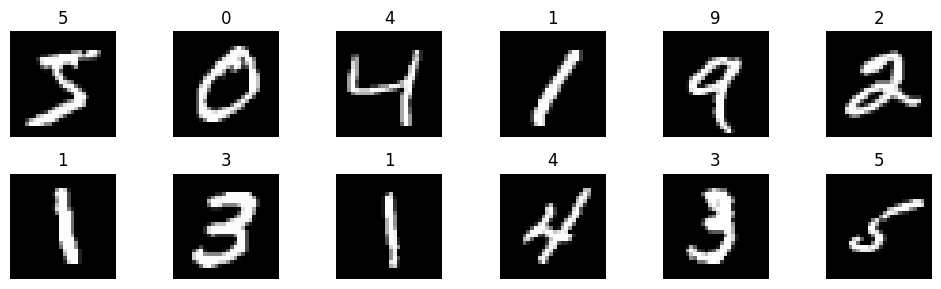

In [2]:
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("x_train shape:", x_train.shape, "| dtype:", x_train.dtype)
print("y_train shape:", y_train.shape, "| dtype:", y_train.dtype)
print("x_test  shape:", x_test.shape,  "| dtype:", x_test.dtype)
print("y_test  shape:", y_test.shape,  "| dtype:", y_test.dtype)

# Visualize a small batch
fig, axes = plt.subplots(2, 6, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap="gray")
    ax.set_title(str(y_train[i]))
    ax.axis("off")
plt.tight_layout()
plt.show()


### 3.2 Normalization and reshaping

The model uses a final **tanh** activation, so I scale pixel values to the range **[-1, 1]**:
- original pixels are in [0, 255]
- normalized pixels become (x - 128) / 128

The dense network expects a 1D vector input, so I flatten 28×28 → 784.


In [3]:
# Normalize to [-1, 1] and flatten to vectors of length 784
norm_x_train = ((x_train - 128.0) / 128.0).reshape([-1, 784]).astype("float32")
norm_x_test  = ((x_test  - 128.0) / 128.0).reshape([-1, 784]).astype("float32")

print("norm_x_train:", norm_x_train.shape, norm_x_train.dtype, "min/max:", norm_x_train.min(), norm_x_train.max())
print("norm_x_test :", norm_x_test.shape,  norm_x_test.dtype,  "min/max:", norm_x_test.min(),  norm_x_test.max())


norm_x_train: (60000, 784) float32 min/max: -1.0 0.9921875
norm_x_test : (10000, 784) float32 min/max: -1.0 0.9921875


### 3.3 Corrupting inputs (masking)

To create corrupted inputs, I randomly drop a fraction of pixels using a Bernoulli mask.
When a pixel is dropped, it becomes 0 (a neutral value under the [-1, 1] scaling).

`p` controls the probability that a pixel is kept.


In [4]:
def generate_masked_inputs(x, p, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mask = np.random.binomial(n=1, p=p, size=x.shape).astype("float32")
    return x * mask

masked_x_train = generate_masked_inputs(norm_x_train, p=0.5, seed=SEED)
masked_x_test  = generate_masked_inputs(norm_x_test,  p=0.5, seed=SEED)

print("masked_x_train:", masked_x_train.shape, masked_x_train.dtype)


masked_x_train: (60000, 784) float32


Visual check: original vs corrupted (first few samples).

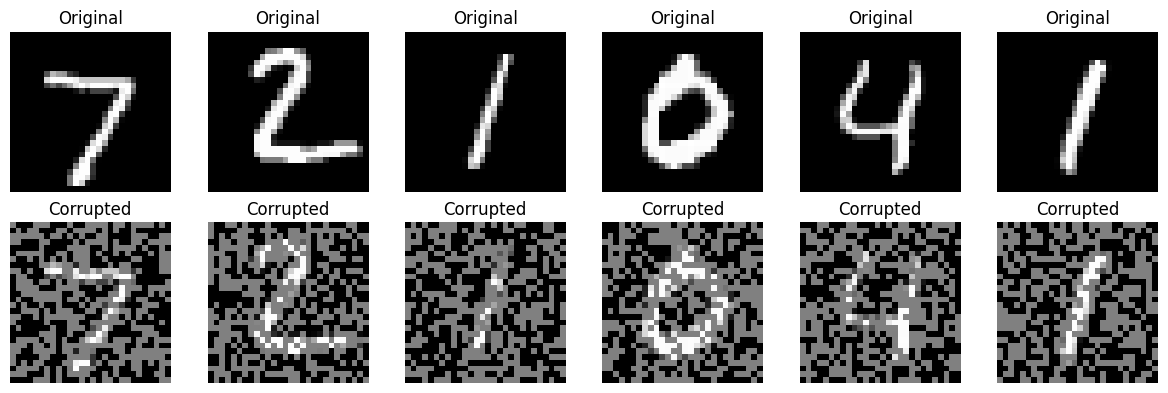

In [5]:
def show_triplets(original, corrupted, reconstructed=None, n=6):
    fig, axes = plt.subplots(3 if reconstructed is not None else 2, n, figsize=(12, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].reshape(28, 28), cmap="gray", vmin=-1, vmax=1)
        axes[0, i].axis("off")
        axes[0, i].set_title("Original")

        axes[1, i].imshow(corrupted[i].reshape(28, 28), cmap="gray", vmin=-1, vmax=1)
        axes[1, i].axis("off")
        axes[1, i].set_title("Corrupted")

        if reconstructed is not None:
            axes[2, i].imshow(reconstructed[i].reshape(28, 28), cmap="gray", vmin=-1, vmax=1)
            axes[2, i].axis("off")
            axes[2, i].set_title("Reconstructed")
    plt.tight_layout()
    plt.show()

show_triplets(norm_x_test, masked_x_test, reconstructed=None, n=6)


### 3.4 Autoencoder model

Architecture (dense / fully connected):
- 784 → 64 → 32 → 64 → 784
- ReLU in hidden layers
- tanh in the output layer

Loss: **mean squared error (MSE)**, since this is a reconstruction problem.


In [6]:
from tensorflow.keras import layers, models

autoencoder = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(784,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(784, activation="tanh"),
])

autoencoder.compile(loss="mse", optimizer="adam")
autoencoder.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,392 (411.69 KB)

 Trainable params: 105,392 (411.69 KB)

 Non-trainable params: 0 (0.00 B)

### 3.5 Training

The target is the original (clean) image vector, while the input is the corrupted vector.


In [7]:
history = autoencoder.fit(
    masked_x_train,
    norm_x_train,
    batch_size=64,
    epochs=10,
    validation_data=(masked_x_test, norm_x_test),
    verbose=1
)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2355 - val_loss: 0.1049
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1039 - val_loss: 0.0948
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0955 - val_loss: 0.0901
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0910 - val_loss: 0.0870
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0877 - val_loss: 0.0840
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0849 - val_loss: 0.0812
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0823 - val_loss: 0.0798
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0807 - val_loss: 0.0788
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0796 - val_loss: 0.0779
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0787 - val_loss: 0.0773


Plot the training curve (MSE).

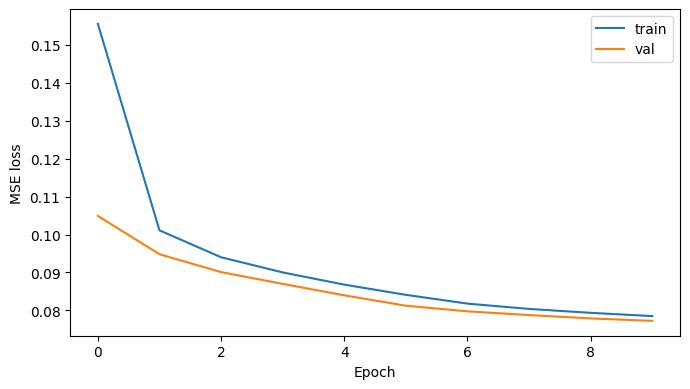

In [8]:
plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.tight_layout()
plt.show()


### 3.6 Reconstruction results

I run the autoencoder on corrupted test inputs and compare:
- original image
- corrupted image
- reconstructed output


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
recon_x_test shape: (10000, 784)


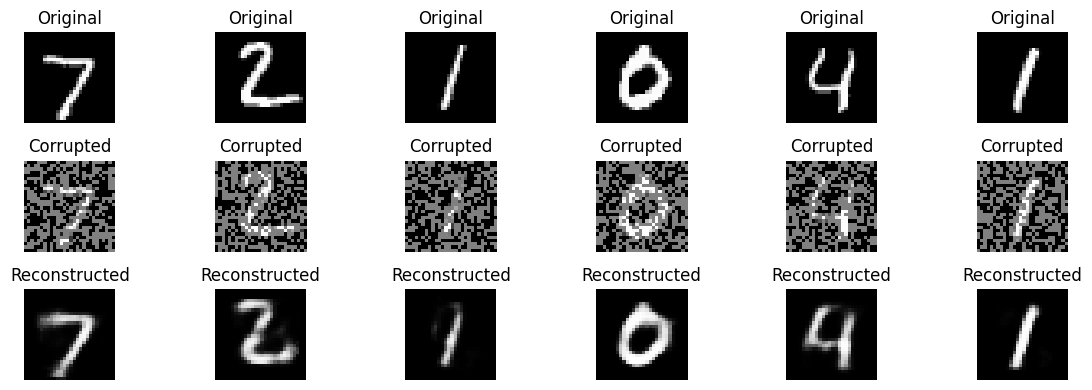

In [9]:
recon_x_test = autoencoder.predict(masked_x_test, batch_size=256)

print("recon_x_test shape:", recon_x_test.shape)
show_triplets(norm_x_test, masked_x_test, reconstructed=recon_x_test, n=6)


## 4) Convolutional Neural Networks — Image Classification (CIFAR-10)

CNNs are a natural fit for images because they learn local patterns (edges, textures, shapes) while preserving spatial structure.

### 4.1 Understanding the data
CIFAR-10 images are 32×32 RGB with 10 classes.


In [10]:
# If tfds is missing, install it in Colab:
# !pip -q install tensorflow-datasets

import tensorflow_datasets as tfds

data = tfds.load("cifar10")
print(data)

# CIFAR-10 label names (standard order used by TFDS)
label_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.RPOIG8_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.RPOIG8_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
{Split('train'): <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, Split('test'): <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


Inspect a few samples from the training split.

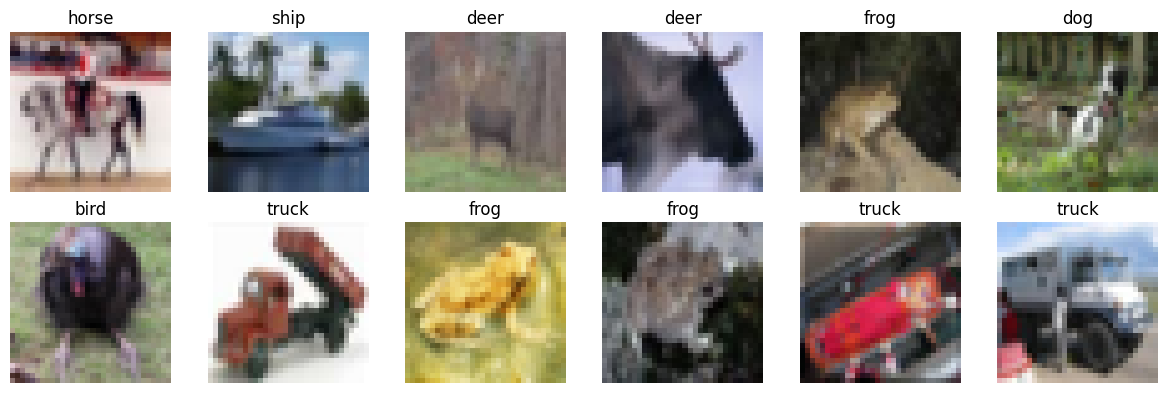

In [11]:
sample = next(iter(data["train"].take(1)))
# data["train"] yields dicts; show a few by iterating
imgs = []
labels = []
for ex in data["train"].take(12):
    imgs.append(ex["image"].numpy())
    labels.append(int(ex["label"].numpy()))

fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for ax, img, lbl in zip(axes.flat, imgs, labels):
    ax.imshow(img)
    ax.set_title(label_names[lbl])
    ax.axis("off")
plt.tight_layout()
plt.show()


### 4.2 Data formatting pipeline

Images arrive as `uint8`. I cast them to `float32`.  
Labels arrive as integer ids. I convert them to one-hot vectors for categorical cross-entropy.


In [12]:
def format_data(x, depth):
    img = tf.cast(x["image"], tf.float32)
    lbl = tf.one_hot(x["label"], depth=depth)
    return img, lbl

BATCH_SIZE = 32

tr_data = data["train"].map(lambda x: format_data(x, depth=10)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
te_data = data["test"].map(lambda x: format_data(x, depth=10)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Inspect one batch
x_batch, y_batch = next(iter(tr_data))
print("x_batch:", x_batch.shape, x_batch.dtype)
print("y_batch:", y_batch.shape, y_batch.dtype)


x_batch: (32, 32, 32, 3) <dtype: 'float32'>
y_batch: (32, 10) <dtype: 'float32'>


### 4.3 CNN model

Model structure:
- 3 convolution layers
- flatten
- 2 dense layers, ending with softmax (10 classes)


In [13]:
cnn = models.Sequential([
    layers.Conv2D(filters=16, kernel_size=(9, 9), strides=(2, 2),
                  activation="relu", padding="valid", input_shape=(32, 32, 3)),
    layers.Conv2D(filters=32, kernel_size=(7, 7), activation="relu", padding="valid"),
    layers.Conv2D(filters=64, kernel_size=(7, 7), activation="relu", padding="same"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

cnn.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["acc"]
)

cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 12, 12, 16)     │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 32)       │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 64)       │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,610 (1.06 MB)

 Trainable params: 277,610 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

### 4.4 Training and evaluation

In [14]:
EPOCHS_CNN = 25  # adjust if you want a quicker run

history_cnn = cnn.fit(tr_data, epochs=EPOCHS_CNN, validation_data=te_data, verbose=1)
test_loss, test_acc = cnn.evaluate(te_data, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - acc: 0.1913 - loss: 2.4929 - val_acc: 0.3025 - val_loss: 1.8853
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.3353 - loss: 1.8296 - val_acc: 0.3675 - val_loss: 1.7359
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.3671 - loss: 1.7417 - val_acc: 0.3764 - val_loss: 1.7438
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.3885 - loss: 1.6899 - val_acc: 0.3822 - val_loss: 1.7409
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.4056 - loss: 1.6423 - val_acc: 0.4041 - val_loss: 1.7163
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.4225 - loss: 1.5954 - val_acc: 0.3901 - val_loss: 1.7637
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.4456 - loss: 1.5322 - val_acc: 0.3973 - val_loss: 1.7299
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.4522 - loss: 1.5065 - val_acc: 0.3907 - val_loss: 1.7890
Epoch 9/25
1563/1563 ━━━━━━━━━━━━━━━━━━

Plot accuracy and loss curves.

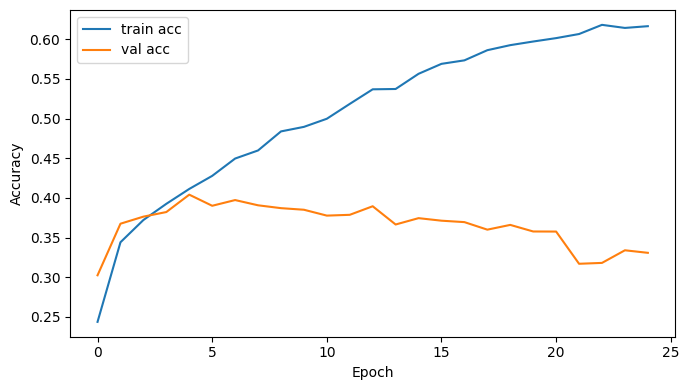

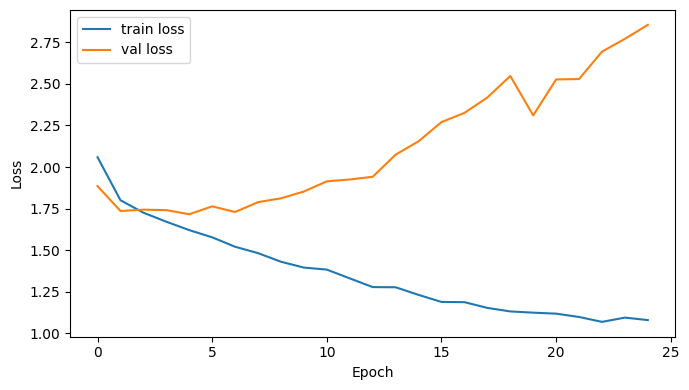

In [15]:
plt.figure(figsize=(7,4))
plt.plot(history_cnn.history["acc"], label="train acc")
plt.plot(history_cnn.history["val_acc"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history_cnn.history["loss"], label="train loss")
plt.plot(history_cnn.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


## 5) Recurrent Neural Networks — CO₂ Forecasting

RNNs are designed for sequence data. Here the input is a sequence of monthly CO₂ measurements.
This is a regression problem, so the output is a continuous value and the loss is MSE.

### 5.1 Understanding the data
The dataset contains monthly CO₂ measurements. I load it from a CSV and then create a differenced series.


                    Date  Decimal Date  Average  Trend
1979-01 1979.042  336.56          0.11   335.92   0.09
1979-02 1979.125  337.29          0.09   336.26   0.09
1979-03 1979.208  337.88          0.11   336.51   0.09
1979-04 1979.292  338.32          0.13   336.72   0.10
1979-05 1979.375  338.26          0.04   336.71   0.10
Index(['Date', 'Decimal Date', 'Average', 'Trend'], dtype='object')


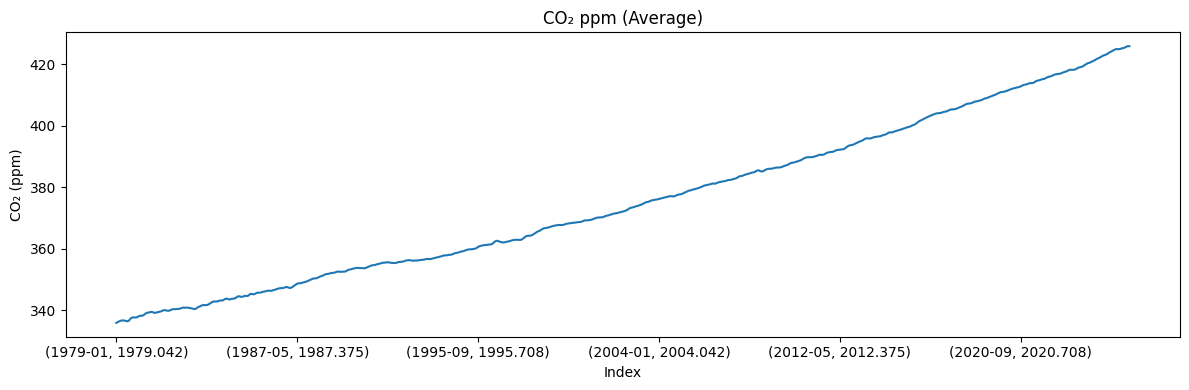

In [16]:
import pandas as pd

url = "https://datahub.io/core/co2-ppm/r/co2-mm-gl.csv"
data_co2 = pd.read_csv(url)

print(data_co2.head())
print(data_co2.columns)

# Plot the raw CO2 series (Average)
data_co2["Average"].plot(figsize=(12,4), title="CO₂ ppm (Average)")
plt.xlabel("Index")
plt.ylabel("CO₂ (ppm)")
plt.tight_layout()
plt.show()


### 5.2 Differencing

The raw CO₂ series trends upward over time. A common preprocessing step is **differencing**:
\[
\mathrm{diff}_t = \mathrm{Average}_t - \mathrm{Average}_{t-1}
\]
This produces a series closer to stationary behavior, which can simplify forecasting.


/tmp/ipython-input-1435511211.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_co2["Average Diff"] = data_co2["Average"] - data_co2["Average"].shift(1).fillna(method="bfill")


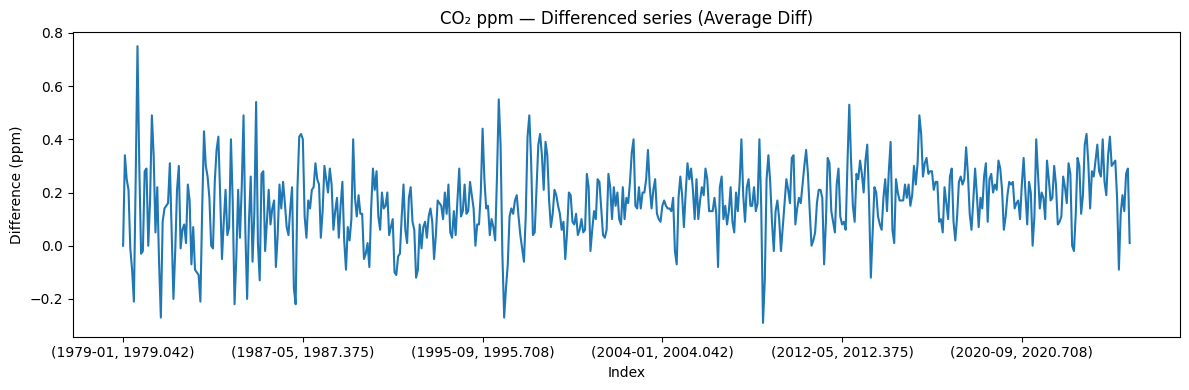

                    Date  Average  Average Diff
1979-01 1979.042  336.56   335.92          0.00
1979-02 1979.125  337.29   336.26          0.34
1979-03 1979.208  337.88   336.51          0.25
1979-04 1979.292  338.32   336.72          0.21
1979-05 1979.375  338.26   336.71         -0.01
1979-06 1979.458  337.39   336.62         -0.09
1979-07 1979.542  335.57   336.41         -0.21
1979-08 1979.625  334.37   336.66          0.25


In [17]:
data_co2["Average Diff"] = data_co2["Average"] - data_co2["Average"].shift(1).fillna(method="bfill")

data_co2["Average Diff"].plot(figsize=(12,4), title="CO₂ ppm — Differenced series (Average Diff)")
plt.xlabel("Index")
plt.ylabel("Difference (ppm)")
plt.tight_layout()
plt.show()

print(data_co2[["Date", "Average", "Average Diff"]].head(8))


### 5.3 Convert the series into sequences

I use a sliding window of length `n_seq`.  
- the input sequence length is `n_seq - 1`  
- the target is the next value (the final element of the window)

This matches a "predict the next step from recent history" setup.


In [18]:
def generate_data(series, n_seq=13):
    series = np.array(series, dtype="float32")
    x, y = [], []
    for i in range(len(series) - n_seq + 1):
        window = series[i:i+n_seq]
        x.append(window[:-1])
        y.append(window[-1])
    x = np.array(x).reshape(-1, n_seq-1, 1)
    y = np.array(y).reshape(-1, 1)
    return x, y

x, y = generate_data(data_co2["Average Diff"], n_seq=13)
print("x shape:", x.shape, "| y shape:", y.shape)
print("Example x[0] (first 5 steps):", x[0, :5, 0])
print("Example y[0]:", y[0, 0])


x shape: (549, 12, 1) | y shape: (549, 1)
Example x[0] (first 5 steps): [ 0.    0.34  0.25  0.21 -0.01]
Example y[0]: 0.28


### 5.4 RNN model

Model structure:
- SimpleRNN(64)
- Dense(64, ReLU)
- Dense(1)

Loss: MSE (regression). Optimizer: Adam.


In [19]:
rnn = models.Sequential([
    layers.SimpleRNN(64, input_shape=(12, 1)),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

rnn.compile(loss="mse", optimizer="adam")
rnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,449 (33.00 KB)

 Trainable params: 8,449 (33.00 KB)

 Non-trainable params: 0 (0.00 B)

### 5.5 Training

In [20]:
EPOCHS_RNN = 25

hist_rnn = rnn.fit(
    x, y,
    shuffle=True,
    batch_size=64,
    epochs=EPOCHS_RNN,
    verbose=1
)


Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0431
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 
Epoch 9/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 
Epoch 10/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 
Epoch 11/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 
Epoch 12/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 
Epoch 13/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 
Epoch 14/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 
Epoch 15/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 
Epoch 16/25
9/9 ━━━━━━━━━━━━━━━━━

Plot the training loss curve.

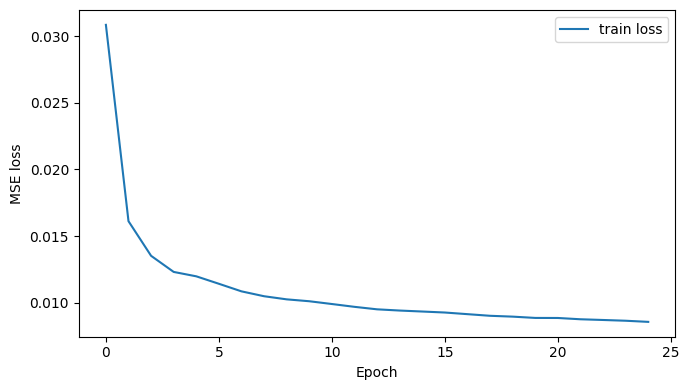

In [21]:
plt.figure(figsize=(7,4))
plt.plot(hist_rnn.history["loss"], label="train loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.tight_layout()
plt.show()


### 5.6 Predicting future CO₂ values

The model predicts the next **difference** value.  
To obtain predicted CO₂ levels, I accumulate predicted differences on top of the last known `Average`.

I predict 12 future steps using an iterative procedure:
- start with the last 12 observed differences
- predict the next difference
- shift the window and append the prediction


In [22]:
future_steps = 12

history = data_co2["Average Diff"].values[-12:].reshape(1, -1, 1).astype("float32")
prev_true = float(data_co2["Average"].values[-1])

pred_diffs = []
pred_levels = []

for _ in range(future_steps):
    p_diff = rnn.predict(history, verbose=0).reshape(1, -1, 1)
    history = np.concatenate((history[:, 1:, :], p_diff), axis=1)
    diff_val = float(p_diff[0, 0, 0])
    prev_true = prev_true + diff_val
    pred_diffs.append(diff_val)
    pred_levels.append(prev_true)

pred_levels[:5], pred_diffs[:5]


([425.9309434418753,
  426.12353305269033,
  426.26686152566225,
  426.3442149137333,
  426.5046797816828],
 [0.0009434418752789497,
  0.19258961081504822,
  0.1433284729719162,
  0.07735338807106018,
  0.16046486794948578])

Plot the predicted future CO₂ levels (continuing from the last known point).

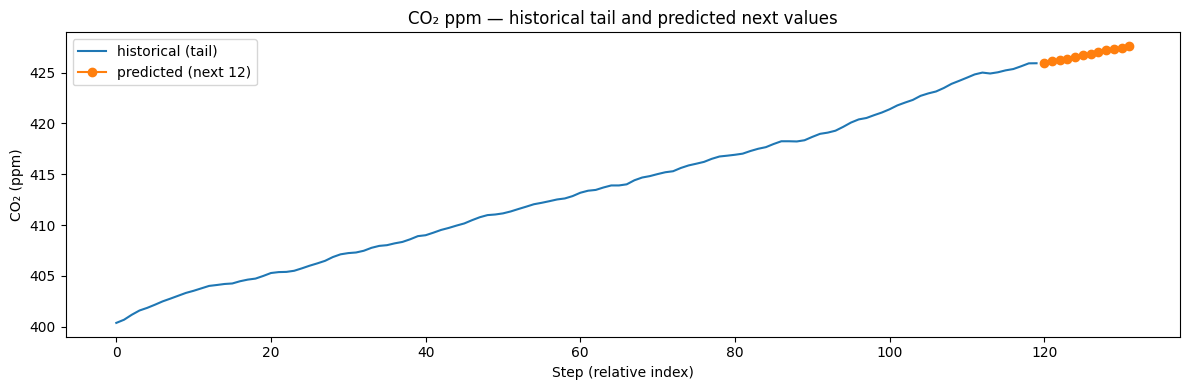

In [23]:
plt.figure(figsize=(12,4))
# Plot last part of the true series
tail_n = 120
plt.plot(range(tail_n), data_co2["Average"].values[-tail_n:], label="historical (tail)")

# Plot predicted points after the historical tail
pred_x = list(range(tail_n, tail_n + future_steps))
plt.plot(pred_x, pred_levels, marker="o", label="predicted (next 12)")

plt.title("CO₂ ppm — historical tail and predicted next values")
plt.xlabel("Step (relative index)")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.tight_layout()
plt.show()


## 6) Takeaways

- Autoencoders demonstrate representation learning: a bottleneck can force the model to learn compact features that are useful for reconstruction.
- CNNs handle images effectively because convolution layers learn local patterns and preserve spatial structure.
- RNNs process sequences and can be applied to time series forecasting; differencing is a simple way to make trending series easier to model.
- Loss functions should match the task: MSE for reconstruction/regression, categorical cross-entropy for multi-class classification.
